#### Instructions
###### Follow the instructions given in comments prefixed with ## and write your code below that.
###### Also fill the partial code in given blanks. 
###### Don't make any changes to the rest part of the codes

### Answer the questions given at the end of this notebook within your report.


### You would need to submit your GitHub repository link. Refer to the Section 6: Final Submission on the PDF document for the details.


In [26]:
%pip install opencv-python-headless numpy matplotlib scikit-learn scipy wandb setuptools


import cv2
import numpy as np
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from scipy.spatial import distance
from matplotlib.offsetbox import OffsetImage, AnnotationBbox


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [27]:
import wandb

wandb.login(key="20ebbc957788d98fe20ccce7c2be533cd7466c68")

wandb.init(project="distance_classification")

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


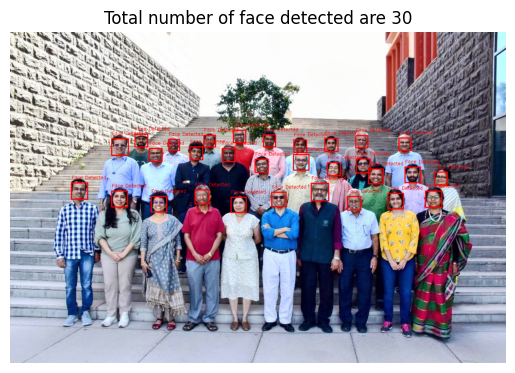

In [28]:
## Reading the image plaksha_Faculty.jpg
img = cv2.imread('plaksha_Faculty.jpg')
  
## Convert the image to grayscale
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  
# Loading the required haar-cascade xml classifier file
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
  
# Applying the face detection method on the grayscale image. 
## Change the parameters for better detection of faces in your case.
faces_rect = face_cascade.detectMultiScale(gray_img, 1.05, 4, minSize=(25,25), maxSize=(50,50))
 
# Define the text and font parameters
text = "Face Detected"
font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 0.4
font_color = (0, 0, 255)  # Red color
font_thickness = 1

# Iterating through rectangles of detected faces
for (x, y, w, h) in faces_rect:
    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 0, 255), 2)
    # Use cv2.putText to add the text to the image, Use text, font, font_scale, font_color, font_thickness here
    cv2.putText(img, text, (x, y - 10), font, font_scale, font_color, font_thickness)
    
## Display the image using matplotlib
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Total number of face detected are {}'.format(len(faces_rect)))
plt.axis('off')
plt.show()

cv2.imwrite('face_detection.jpg', img)

wandb.log({"Detected Faces": len(faces_rect)})
wandb.log({"Face Detection Image": wandb.Image("face_detection.jpg")})

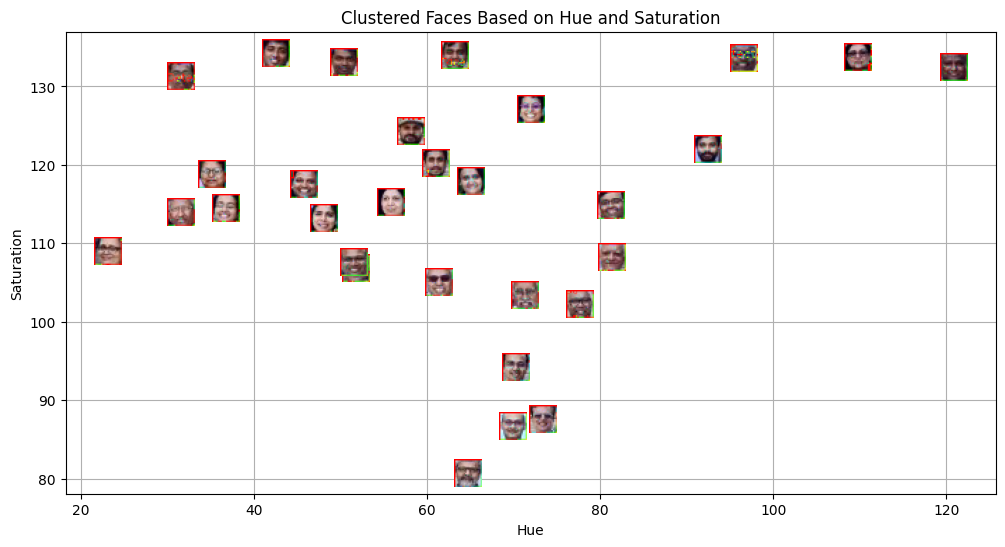

In [29]:

from matplotlib.offsetbox import OffsetImage, AnnotationBbox
# Extract face region features (Hue and Saturation)
img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
hue_saturation = []
face_images = []  # To store detected face images

for (x, y, w, h) in faces_rect:
    face = img_hsv[y:y + h, x:x + w]
    hue = np.mean(face[:, :, 0])
    saturation = np.mean(face[:, :, 1])
    hue_saturation.append((hue, saturation))
    face_images.append(face)

hue_saturation = np.array(hue_saturation)

## Perform k-Means clustering on hue_saturation and store in kmeans
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
kmeans.fit(hue_saturation)
centroids = kmeans.cluster_centers_
labels = kmeans.labels_

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the clustered faces with custom markers
for i, (x,y,w,h ) in enumerate(faces_rect):
    im = OffsetImage(cv2.cvtColor(cv2.resize(face_images[i], (20, 20)), cv2.COLOR_HSV2RGB))
    ab = AnnotationBbox(im, (hue_saturation[i, 0], hue_saturation[i, 1]), frameon=False, pad=0)
    ax.add_artist(ab)
    plt.plot(hue_saturation[i, 0], hue_saturation[i, 1])
    

plt.xlabel("Hue")
plt.ylabel("Saturation")
plt.title("Clustered Faces Based on Hue and Saturation")
plt.grid(True)

# Show the plot
plt.show()

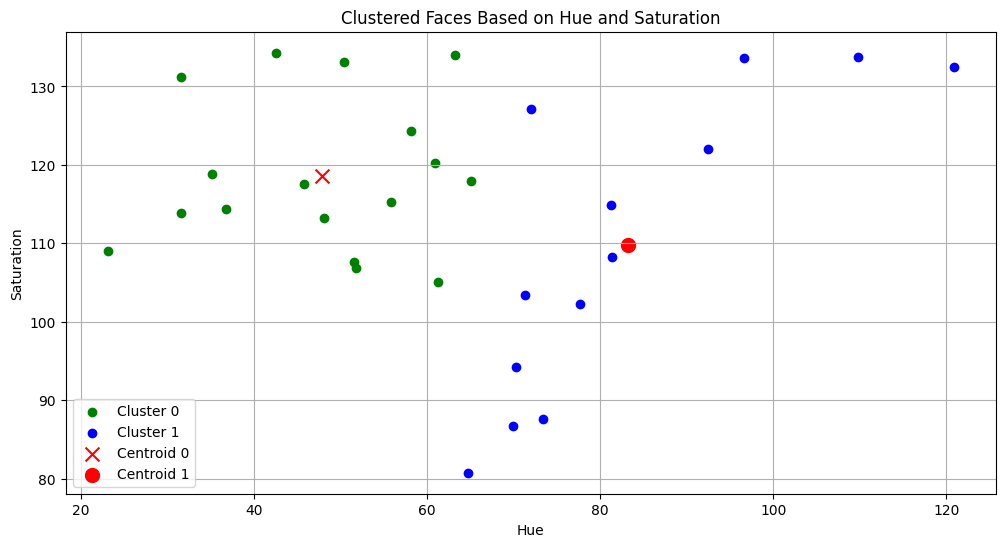

In [30]:
# Create an empty list to store legend labels
legend_labels = []

# Create lists to store points for each cluster
cluster_0_points = []
cluster_1_points = []

# Your code for scatter plot goes here
fig, ax = plt.subplots(figsize=(12, 6))
for i, (x, y, w, h) in enumerate(faces_rect):
    if kmeans.labels_[i] == 0:
        cluster_0_points.append((hue_saturation[i, 0], hue_saturation[i, 1]))
    else:
        cluster_1_points.append((hue_saturation[i, 0], hue_saturation[i, 1]))


cluster_0_points = np.array(cluster_0_points)
# Plot points for cluster 0 in green
plt.scatter(cluster_0_points[:, 0], cluster_0_points[:, 1], c='g', label='Cluster 0')


cluster_1_points = np.array(cluster_1_points)
# Plot points for cluster 1 in blue
plt.scatter(cluster_1_points[:, 0], cluster_1_points[:, 1], c='b', label='Cluster 1')

# Calculate and plot centroids
centroid_0 = centroids[0]
centroid_1 = centroids[1]

# Plot both the centroid for cluster 0 and cluster 1 
plt.scatter(centroid_0[0], centroid_0[1], c='r', marker='x', s=100, label='Centroid 0')
plt.scatter(centroid_1[0], centroid_1[1], c='r', marker='o', s=100, label='Centroid 1')

plt.xlabel("Hue")
plt.ylabel("Saturation")
plt.title("Clustered Faces Based on Hue and Saturation")
plt.legend()
plt.grid(True)

plt.savefig("clustered_faces.png")
plt.show()

all_tab = wandb.Table(columns=["Hue", "Saturation", "Cluster"])
for i, (x, y, w, h) in enumerate(faces_rect):
    all_tab.add_data(hue_saturation[i, 0], hue_saturation[i, 1], labels[i])
    
wandb.log({"Clustered Faces Image": wandb.Image("clustered_faces.png")})


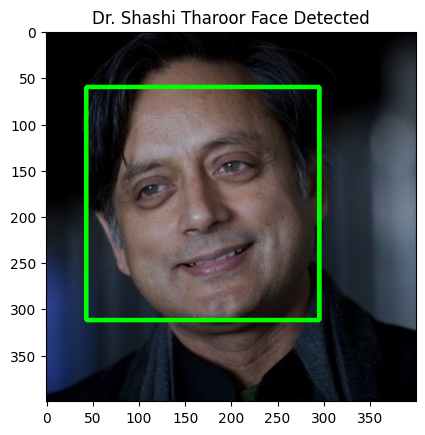

In [31]:
## Read the class of the template image 'Dr_Shashi_Tharoor.jpg' using cv2 and store it in template_img
template_img = cv2.imread('Dr_Shashi_Tharoor.jpg')
temp_gray = cv2.cvtColor(template_img, cv2.COLOR_BGR2GRAY)

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

# Detect face  in the template image after converting it to gray and store it in template_faces
template_faces = face_cascade.detectMultiScale(temp_gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

# Draw rectangles around the detected faces
for (x, y, w, h) in template_faces:
    cv2.rectangle(template_img, (x, y), (x + w, y + h), (0, 255, 0), 3)


# Display the image using matplotlib
plt.imshow(cv2.cvtColor(template_img, cv2.COLOR_BGR2RGB))
plt.title('Dr. Shashi Tharoor Face Detected')
plt.show()

cv2.imwrite('template_face_detection.jpg', template_img)
wandb.log({"Dr. Shashi Tharoor Face Detection Image": wandb.Image("template_face_detection.jpg")})  



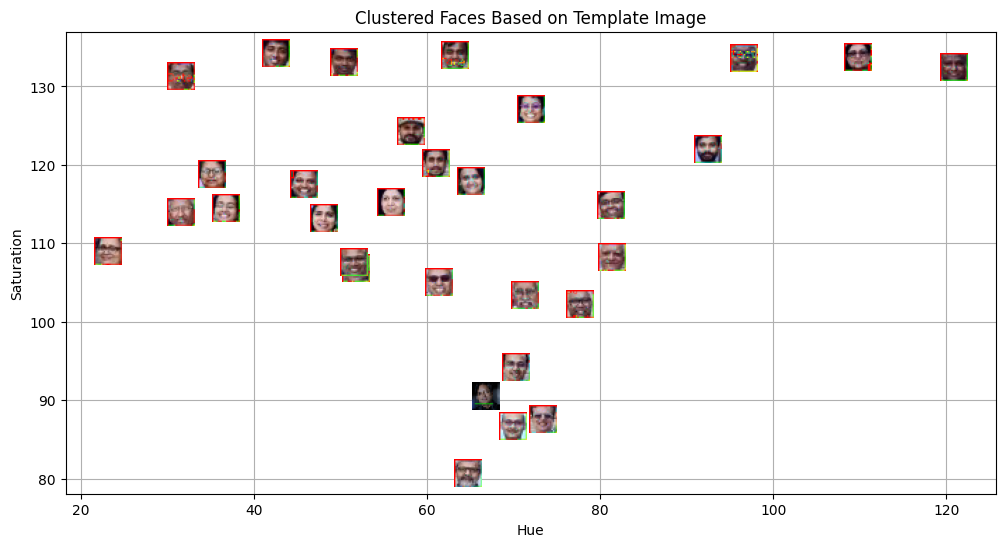

<Figure size 640x480 with 0 Axes>

In [32]:
# Convert the template image to HSV color space and store it in template_hsv
template_hsv = cv2.cvtColor(template_img, cv2.COLOR_BGR2HSV)

# Extract hue and saturation features from the template image as we did it for detected faces.
template_hue = np.mean(template_hsv[:, :, 0])
template_saturation = np.mean(template_hsv[:, :, 1])

# Predict the cluster label for the template image and store it in template_label
template_label = kmeans.predict([[template_hue, template_saturation]])[0]

# Create a figure and axis for visualization
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the clustered faces with custom markers (similar to previous code)
for i, (x, y, w, h) in enumerate(faces_rect):
    color = 'red' if kmeans.labels_[i] == 0 else 'blue'
    im = OffsetImage(cv2.cvtColor(cv2.resize(face_images[i], (20, 20)), cv2.COLOR_HSV2RGB))
    ab = AnnotationBbox(im, (hue_saturation[i, 0], hue_saturation[i, 1]), frameon=False, pad=0)
    ax.add_artist(ab)
    plt.plot(hue_saturation[i, 0], hue_saturation[i, 1], 'o', markersize=5, color=color)

# Plot the template image in the respective cluster
if template_label == 0:
    color = 'red'
else:
    color = 'blue'
im = OffsetImage(cv2.cvtColor(cv2.resize(template_img, (20, 20)), cv2.COLOR_BGR2RGB))
ab = AnnotationBbox(im, (template_hue, template_saturation), frameon=False, pad=0)
ax.add_artist(ab)

plt.xlabel("Hue")
plt.ylabel("Saturation")
plt.title("Clustered Faces Based on Template Image")
plt.grid(True)
plt.show()

plt.savefig("clustered_faces_with_template.png")
wandb.log({"Clustered Faces with Template Image": wandb.Image("clustered_faces_with_template.png")})


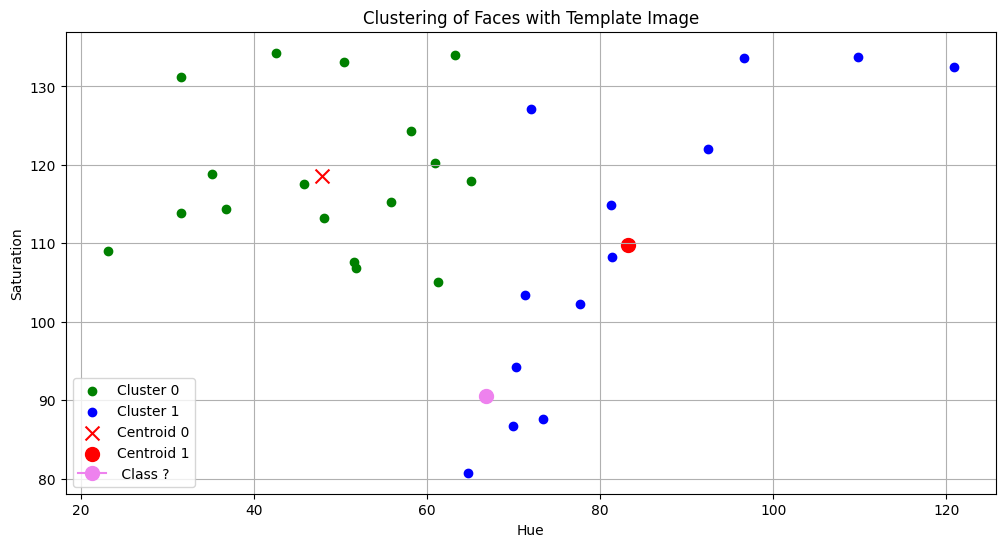

Detected Faces,▁▁▁
Detected Faces,30


In [33]:
# Create an empty list to store legend labels
legend_labels = []

# Create lists to store points for each cluster
cluster_0_points = []
cluster_1_points = []

# Your code for scatter plot goes here
fig, ax = plt.subplots(figsize=(12, 6))
for i, (x, y, w, h) in enumerate(faces_rect):
    if kmeans.labels_[i] == 0:
        cluster_0_points.append((hue_saturation[i, 0], hue_saturation[i, 1]))
    else:
        cluster_1_points.append((hue_saturation[i, 0], hue_saturation[i, 1]))

# Plot points for cluster 0 in green
cluster_0_points = np.array(cluster_0_points)
plt.scatter(cluster_0_points[:, 0], cluster_0_points[:, 1], c='g', label='Cluster 0')

# Plot points for cluster 1 in blue
cluster_1_points = np.array(cluster_1_points)
plt.scatter(cluster_1_points[:, 0], cluster_1_points[:, 1], c='b', label='Cluster 1')

# Calculate and plot centroids for both the clusters
centroid_0 = centroids[0]
centroid_1 = centroids[1]
plt.scatter(centroid_0[0], centroid_0[1], c='r', marker='x', s=100, label='Centroid 0')
plt.scatter(centroid_1[0], centroid_1[1], c='r', marker='o', s=100, label='Centroid 1')

plt.plot(template_hue, template_saturation, marker='o', c= 'violet',markersize= 10, label=' Class ?' )

plt.xlabel("Hue")
plt.ylabel("Saturation")
plt.title("Clustering of Faces with Template Image")
plt.legend()
plt.grid(True)

plt.savefig("clustered_faces_with_template_scatter.png")
plt.show()

wandb.log({"Clustered Faces with Template Image Scatter": wandb.Image("clustered_faces_with_template_scatter.png")})
wandb.finish()

## Report:
## Answer the following questions within your report:
